In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import tqdm
from pathlib import Path

In [2]:

def dataframe_to_latex(
    df, 
    column_format=None, 
    caption=None, 
    label=None, 
    header=True, 
    index=False, 
    float_format="%.2f"
):
    if column_format is None:
        column_format = "l" * (len(df.columns) + (1 if index else 0))
    # Replace _ by ' ' in column names and values
    df.columns = df.columns.str.replace('_', ' ')
    # Replace _ by ' ' in values
    df = df.applymap(lambda x: str(x).replace('_', ' '))
     # For float columns, round to 2 decimal places
    for col in df.select_dtypes(include=[np.float64]).columns:
        df[col] = df[col].round(2)
    # Convert the DataFrame to LaTeX
    latex_str = df.to_latex(
        index=index,
        column_format=column_format,
        header=header,
        float_format=float_format,
        escape=False,  # Allows LaTeX-specific characters (e.g., \%)
    )
    
    # Add optional caption and label
    if caption or label:
        latex_table = "\\begin{table}[ht]\n\\centering\n"
        if caption:
            latex_table += f"\\caption{{{caption}}}\n"
        if label:
            latex_table += f"\\label{{{label}}}\n"
        latex_table += latex_str
        latex_table += "\\end{table}"
    else:
        latex_table = latex_str
    
    return latex_table


In [3]:
results_path = "../results/epxlainability_benchamrk"
full_results_df = pd.DataFrame()

In [4]:
# For all folder in results_path
for experiment_folder in os.listdir(results_path):
    # Load the data
    # if experiment starts with DDPM skip
    if experiment_folder.startswith("DDPM"):
        continue
    for dataset_folder in os.listdir(os.path.join(results_path, experiment_folder)):
        try:
            dataset_results = pd.read_csv(Path(results_path, experiment_folder,dataset_folder, "model_metrics.csv"))
        except:
            print(f"Error loading {results_path}/{experiment_folder}/{dataset_folder}/model_metrics.csv")
            continue
        dataset_results["experiment"] = experiment_folder
        dataset_results["dataset_name"] = "_".join(dataset_folder.split("_")[:-1])
        dataset_results['dataset_version'] = dataset_folder.split("_")[-1]
        full_results_df = pd.concat([full_results_df, dataset_results])


Error loading ../results/epxlainability_benchamrk/DTECategorical_dataset_sampling_deterministic_0.5_s0/synthetic_f1000_s5000_c40_r0.01_0.01_0.01_0.01_0.01_v4/model_metrics.csv
Error loading ../results/epxlainability_benchamrk/DTECategorical_dataset_sampling_deterministic_0.5_s0/synthetic_f1000_s5000_c40_r0.01_0.01_0.01_0.01_0.01_v3/model_metrics.csv
Error loading ../results/epxlainability_benchamrk/DTECategorical_dataset_sampling_deterministic_0.5_s0/synthetic_f1000_s5000_c40_r0.01_0.01_0.01_0.01_0.01_v2/model_metrics.csv
Error loading ../results/epxlainability_benchamrk/DTECategorical_dataset_sampling_deterministic_0.5_s0/synthetic_f1000_s5000_c40_r0.01_0.01_0.01_0.01_0.01_v1/model_metrics.csv
Error loading ../results/epxlainability_benchamrk/DTECategorical_dataset_sampling_deterministic_exponential_s0/synthetic_f1000_s5000_c40_r0.01_0.01_0.01_0.01_0.01_v0/model_metrics.csv
Error loading ../results/epxlainability_benchamrk/DTECategorical_unsupervised_None_s0/synthetic_f1000_s5000_c40_

In [5]:
full_results_df = full_results_df.drop(columns=["Unnamed: 0", "model_name", "sampling_method"], )
full_results_df.head()

,training_time,inference_time,f1_score,dataset_name,training_method,random_seed,aucroc,feature_importance_ndcg,shap_feature_importance_ndcg,global_explanation_time,local_explanation_time,shap_explanation_time,experiment,dataset_version
0,152.779132,0.055405,0.776000,synthetic_f100_s5000_c40_r0.02_0.02_0.02_0.02_...,unsupervised,0,0.901602,0.633476,0.623885,128.561823,684.078592,2369.153448,DTEC_unsupervised,v3
0,149.941046,0.053073,0.884571,synthetic_f100_s5000_c40_r0.02_0.02_0.02_0.02_...,unsupervised,0,0.972246,0.744063,0.696045,126.614622,680.733151,2369.362068,DTEC_unsupervised,v2
0,131.114720,0.049304,0.730000,synthetic_f4_s5000_c2_r0.05_0.05,unsupervised,0,0.882401,0.696142,0.718090,7.865400,120.448710,153.214029,DTEC_unsupervised,v3
0,134.501464,0.048061,0.708571,synthetic_f100_s5000_c40_r0.01_0.01_0.01_0.01_...,unsupervised,0,0.875809,0.465503,0.542892,127.427966,686.874216,2531.023978,DTEC_unsupervised,v0
0,147.014005,0.047014,0.702857,synthetic_f4_s5000_c2_r0.05_0.05,unsupervised,0,0.870688,0.691145,0.686258,8.094566,125.917863,158.752545,DTEC_unsupervised,v0


In [6]:
# Compute mean and std for each dataset with different version, but same experiment name
temp_df = full_results_df.drop(columns=['training_method', "dataset_version"])
mean_df = temp_df.groupby(["experiment", "dataset_name"]).mean().reset_index()
std_df = temp_df.groupby(["experiment", "dataset_name"]).std().reset_index()



In [7]:
# Drop rows where the synthetic data contains 1000 features, described by the number after 'f' in the dataset name
mean_df = mean_df[~mean_df["dataset_name"].str.contains("f1000")]
std_df = std_df[~std_df["dataset_name"].str.contains("f1000")]
full_results_df = full_results_df[~full_results_df["dataset_name"].str.contains("f1000")]



In [8]:
print(full_results_df['experiment'].unique())
print(full_results_df['dataset_name'].unique())

['DTEC_unsupervised' 'DTEC_DSIL_cosine' 'DTEC_DSIL_fixed' 'DTEC_DSIL_exp']
['synthetic_f100_s5000_c40_r0.02_0.02_0.02_0.02_0.02'
 'synthetic_f4_s5000_c2_r0.05_0.05'
 'synthetic_f100_s5000_c40_r0.01_0.01_0.01_0.01_0.01'
 'synthetic_f4_s5000_c2_r0.025_0.025'
 'synthetic_f10_s5000_c4_r0.0175_0.0175_0.0175'
 'synthetic_f50_s5000_c12_r0.02_0.02_0.02_0.02_0.02'
 'synthetic_f10_s5000_c4_r0.035_0.035_0.035'
 'synthetic_f50_s5000_c12_r0.01_0.01_0.01_0.01_0.01']


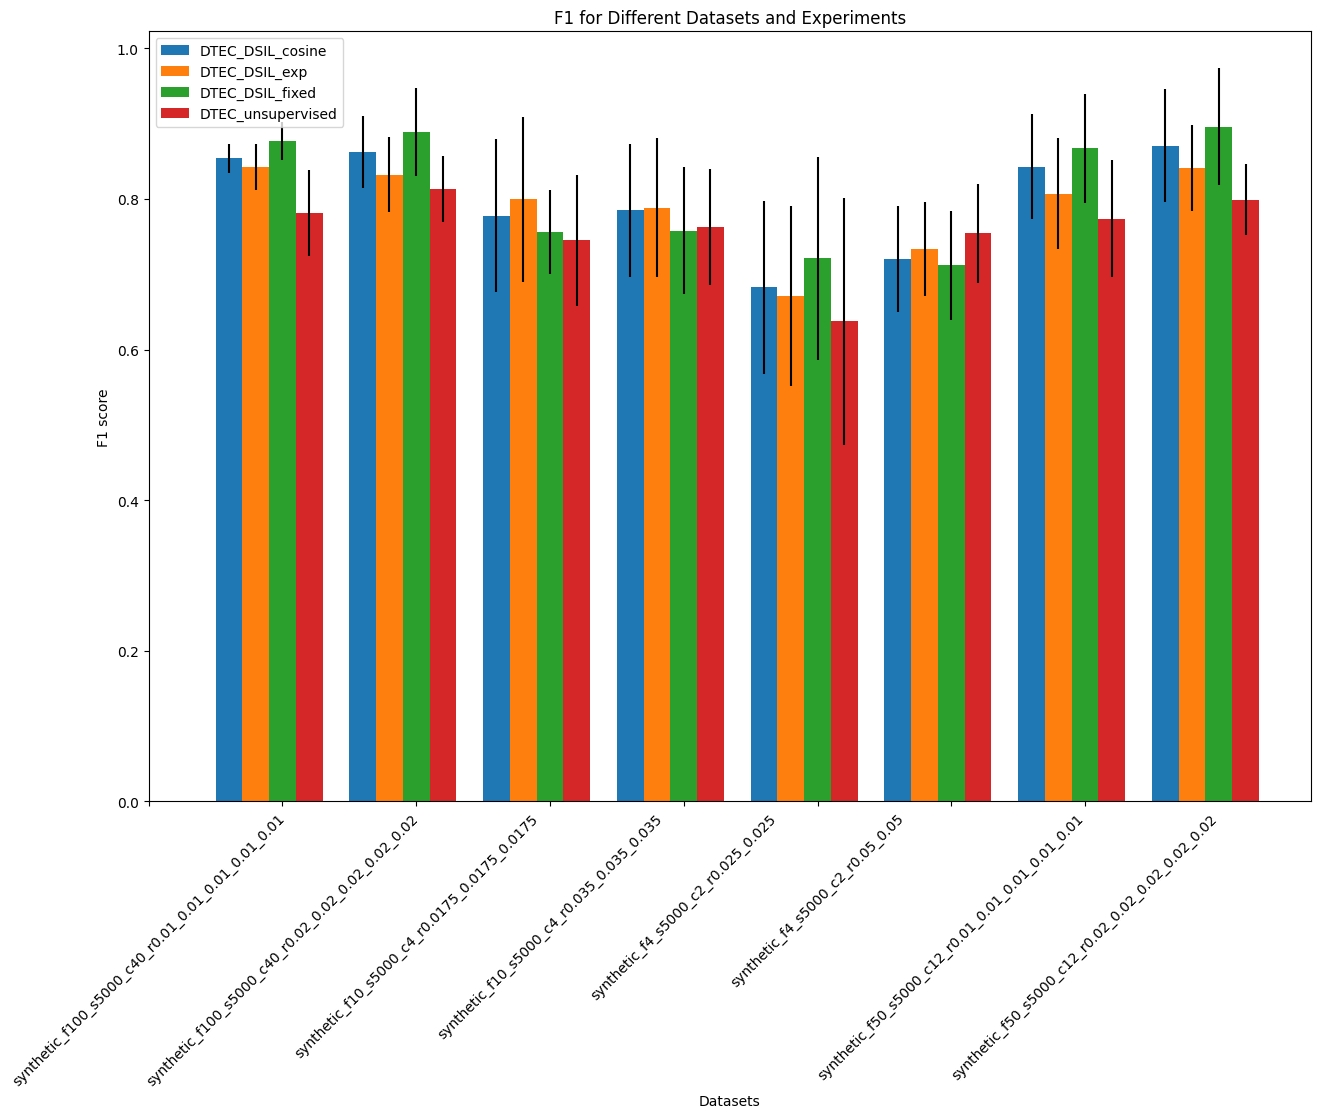

In [9]:
datasets = mean_df["dataset_name"].unique()
experiments = mean_df["experiment"].unique()
num_datasets = len(datasets)
num_experiments = len(experiments)

r = np.arange(num_datasets)
bar_width = 0.2
# Create the plot
fig, ax = plt.subplots(figsize=(15, 10))

# Plot each experiment's accuracy as a bar
for i, experiment in enumerate(experiments):
    experiment_mean = mean_df[mean_df["experiment"] == experiment]
    experiment_std = std_df[std_df["experiment"] == experiment]
    f1_score = experiment_mean.sort_values(by="dataset_name")["f1_score"].values
    std_devs = experiment_std.sort_values(by="dataset_name")["f1_score"].values
    ax.bar(r + i * bar_width, f1_score, width=bar_width, yerr=std_devs, label=experiment)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Datasets')
ax.set_ylabel('F1 score')
ax.set_title('F1 for Different Datasets and Experiments')
ax.set_xticks(r - 1 + bar_width * (num_experiments) / 2)
ax.set_xticklabels(datasets)
ax.legend()

# Show the plot
plt.xticks(rotation=45)
plt.show()

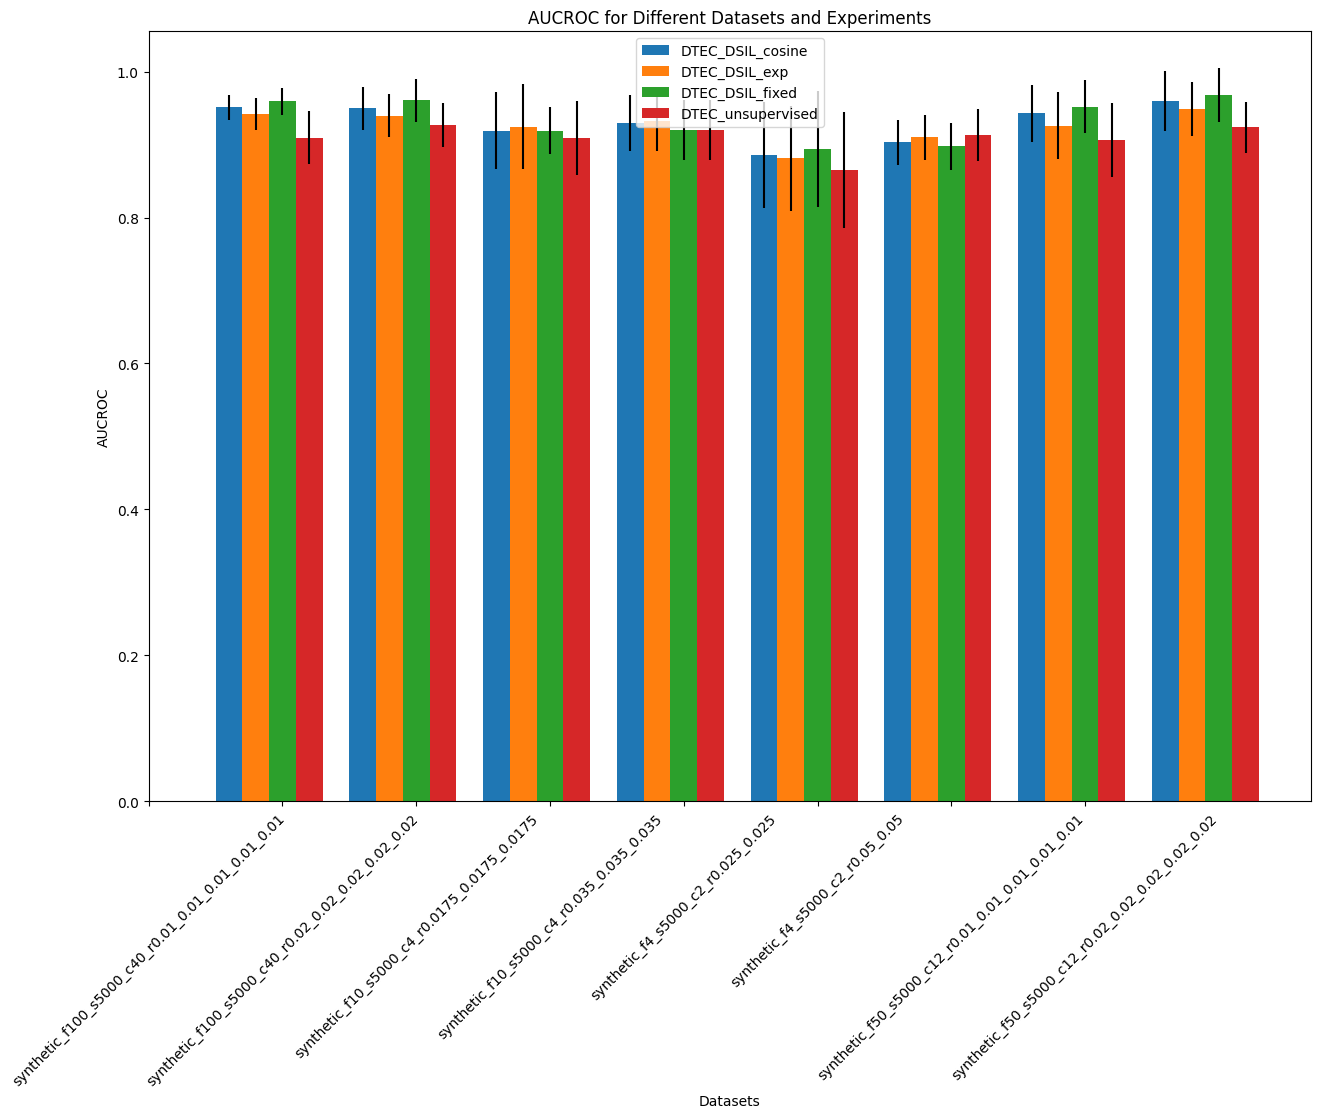

In [10]:
datasets = mean_df["dataset_name"].unique()
experiments = mean_df["experiment"].unique()
num_datasets = len(datasets)
num_experiments = len(experiments)

r = np.arange(num_datasets)
bar_width = 0.2
# Create the plot
fig, ax = plt.subplots(figsize=(15, 10))

# Plot each experiment's accuracy as a bar
for i, experiment in enumerate(experiments):
    experiment_mean = mean_df[mean_df["experiment"] == experiment]
    experiment_std = std_df[std_df["experiment"] == experiment]
    aucroc_score = experiment_mean.sort_values(by="dataset_name")["aucroc"].values
    std_devs = experiment_std.sort_values(by="dataset_name")["aucroc"].values
    ax.bar(r + i * bar_width, aucroc_score, width=bar_width, yerr=std_devs, label=experiment)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Datasets')
ax.set_ylabel('AUCROC')
ax.set_title('AUCROC for Different Datasets and Experiments')
ax.set_xticks(r - 1 + bar_width * (num_experiments) / 2)
ax.set_xticklabels(datasets)
ax.legend()

# Show the plot
plt.xticks(rotation=45)
plt.show()

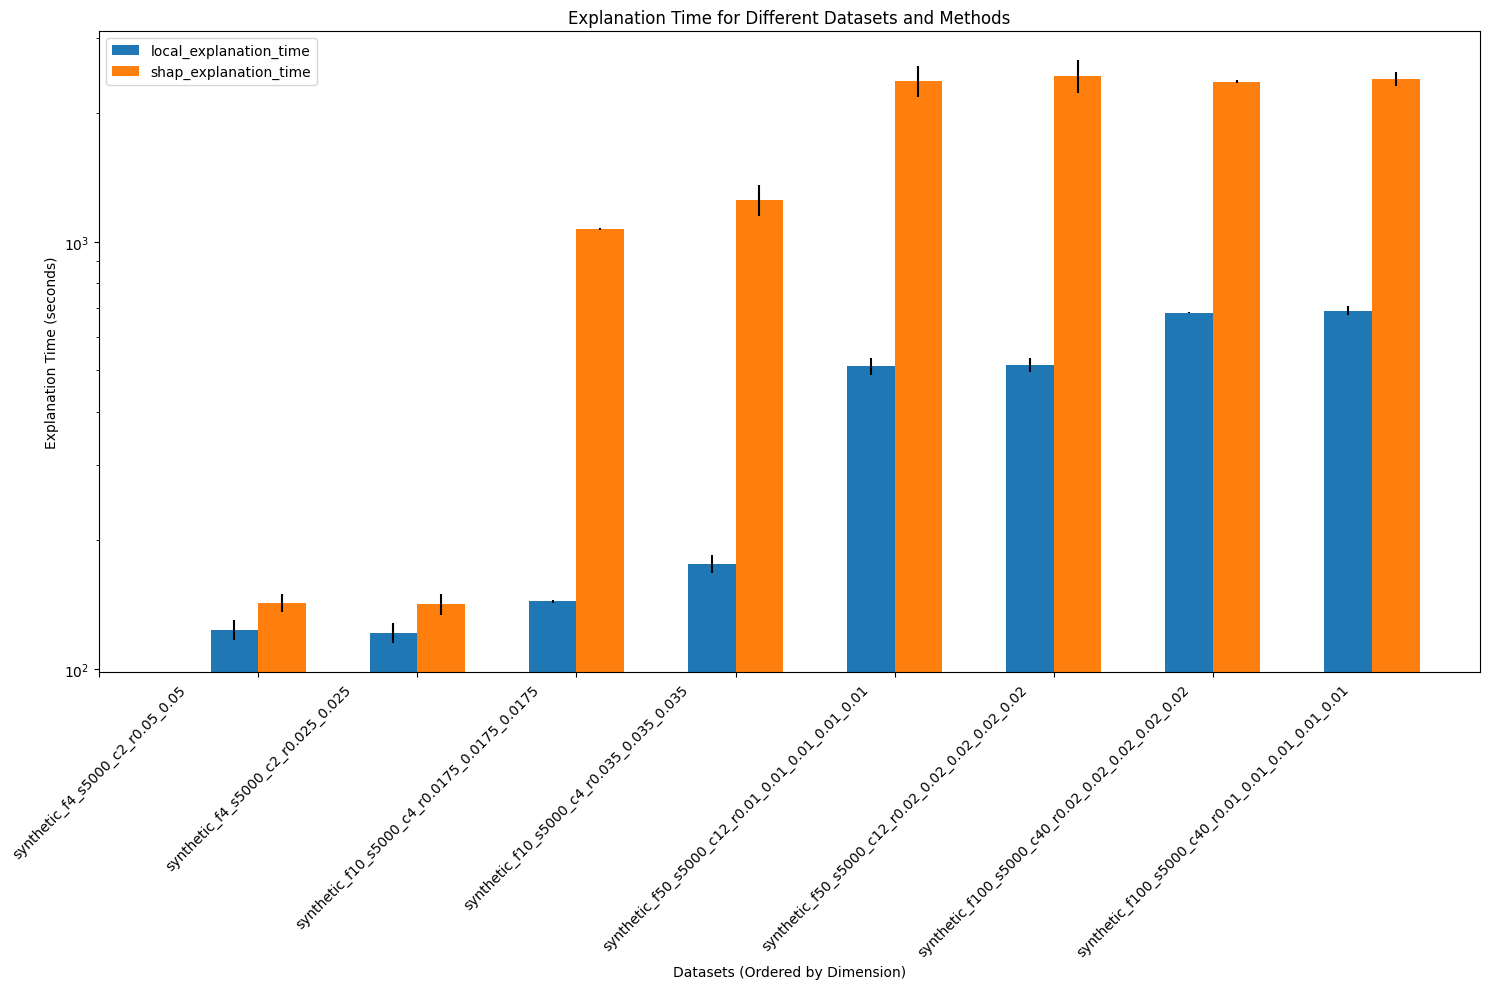

In [11]:
# Extract the dimensions from the dataset names and sort datasets by dimension
mean_df['dimension'] = mean_df['dataset_name'].str.extract(r"f(\d+)", expand=False).astype(int)
std_df['dimension'] = std_df['dataset_name'].str.extract(r"f(\d+)", expand=False).astype(int)

# Sort datasets by dimension
mean_df = mean_df.sort_values('dimension')
std_df = std_df.sort_values('dimension')
datasets = mean_df['dataset_name'].unique()

# Extract unique methods
methods = ["local_explanation_time", "shap_explanation_time"]
num_datasets = len(datasets)
num_methods = len(methods)

r = np.arange(num_datasets)
bar_width = 0.3  # Adjust bar width to fit the methods

# Create the plot
fig, ax = plt.subplots(figsize=(15, 10))

# Plot each method's average explanation time as a bar
for i, method in enumerate(methods):
    method_mean = mean_df.groupby("dataset_name")[method].mean().reindex(datasets)
    method_std = std_df.groupby("dataset_name")[method].std().reindex(datasets)
    ax.bar(r + i * bar_width, method_mean.values, width=bar_width, yerr=method_std.values, label=method)

# Add labels, title, and customize the x-axis
ax.set_xlabel('Datasets (Ordered by Dimension)')
ax.set_ylabel('Explanation Time (seconds)')
ax.set_title('Explanation Time for Different Datasets and Methods')
ax.set_xticks(r -1 + bar_width * (num_methods - 1) / 2)
ax.set_xticklabels(datasets)
ax.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.yscale('log')
# Show the plot
plt.tight_layout()
plt.show()


In [12]:
# Step 1: Merge DataFrames on common columns
merged_df = pd.merge(mean_df, std_df, on=["dataset_name", "experiment"], suffixes=('_mean', '_std'))
# Step 2: Combine mean and std into a single column with "mean(std)" format
merged_df["f1_score_str"] = merged_df.apply(
    lambda row: f"${row['f1_score_mean']:.2f}({row['f1_score_std']:.2f})$", axis=1
)
# RAtio are stored in the string as r{ratio1}_{ratio2}_..._{ratioN}
ratios = merged_df['dataset_name'].str.extract(r'r([0-9]*\.?[0-9]+)|_([0-9]*\.?[0-9]+)')
# Remove empty ratio
# Combine the two capture groups and drop NaNs
ratios = ratios.apply(lambda x: x[0] if pd.notnull(x[0]) else x[1], axis=1).astype(float)

# Sum the ratios grouped by the dataset index
merged_df['anomaly_ratio'] = ratios.groupby(level=0).sum()

# Step 3: Drop the separate mean and std columns if needed
merged_df = merged_df.drop(columns=["f1_score_mean", "f1_score_std"])
print(merged_df.columns)
latex_table = dataframe_to_latex(
    merged_df[['experiment', 'dataset_name', "anomaly_ratio",'f1_score_str']],
    column_format="llc",  
    caption="Mean and Standard Deviation of F1 score for Different Experiments and Datasets",
    label="tab:mean_std",
    index=False
)
with open("latex_table.tex", "w") as f:
    f.write(latex_table)
latex_table.replace("\n", " ")

Index(['experiment', 'dataset_name', 'training_time_mean',
       'inference_time_mean', 'random_seed_mean', 'aucroc_mean',
       'feature_importance_ndcg_mean', 'shap_feature_importance_ndcg_mean',
       'global_explanation_time_mean', 'local_explanation_time_mean',
       'shap_explanation_time_mean', 'dimension_mean', 'training_time_std',
       'inference_time_std', 'random_seed_std', 'aucroc_std',
       'feature_importance_ndcg_std', 'shap_feature_importance_ndcg_std',
       'global_explanation_time_std', 'local_explanation_time_std',
       'shap_explanation_time_std', 'dimension_std', 'f1_score_str',
       'anomaly_ratio'],
      dtype='object')


/tmp/ipykernel_2917414/2472381602.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: str(x).replace('_', ' '))


'\\begin{table}[ht] \\centering \\caption{Mean and Standard Deviation of F1 score for Different Experiments and Datasets} \\label{tab:mean_std} \\begin{tabular}{llc} \\toprule experiment & dataset name & anomaly ratio & f1 score str \\\\ \\midrule DTEC DSIL cosine & synthetic f4 s5000 c2 r0.05 0.05 & 0.05 & $0.72(0.07)$ \\\\ DTEC DSIL cosine & synthetic f4 s5000 c2 r0.025 0.025 & 0.025 & $0.68(0.12)$ \\\\ DTEC DSIL exp & synthetic f4 s5000 c2 r0.025 0.025 & 0.025 & $0.67(0.12)$ \\\\ DTEC DSIL exp & synthetic f4 s5000 c2 r0.05 0.05 & 0.05 & $0.73(0.06)$ \\\\ DTEC unsupervised & synthetic f4 s5000 c2 r0.05 0.05 & 0.05 & $0.75(0.07)$ \\\\ DTEC unsupervised & synthetic f4 s5000 c2 r0.025 0.025 & 0.025 & $0.64(0.16)$ \\\\ DTEC DSIL fixed & synthetic f4 s5000 c2 r0.025 0.025 & 0.025 & $0.72(0.13)$ \\\\ DTEC DSIL fixed & synthetic f4 s5000 c2 r0.05 0.05 & 0.05 & $0.71(0.07)$ \\\\ DTEC DSIL fixed & synthetic f10 s5000 c4 r0.0175 0.0175 0.0175 & 0.0175 & $0.76(0.06)$ \\\\ DTEC DSIL fixed & synt

In [13]:
# Step 1: Merge DataFrames on common columns
merged_df = pd.merge(mean_df, std_df, on=["dataset_name", "experiment"], suffixes=('_mean', '_std'))
import re
# Step 2: Combine mean and std into a single column with "mean(std)" format
merged_df["f1_score_str"] = merged_df.apply(
    lambda row: f"${row['f1_score_mean']:.2f}({row['f1_score_std']:.2f})$", axis=1
)

# Step 3: Extract and sum anomaly ratios
# RAtio are stored in the string as r{ratio1}_{ratio2}_..._{ratioN}

# Define a function to extract and sum all ratios from the dataset name
def extract_ratios(dataset_name):
    # Use re.findall to capture all numerical ratios
    ratios = re.findall(r'r([0-9]*\.?[0-9]+)|_([0-9]*\.?[0-9]+)', dataset_name)
    # Flatten the list of tuples and filter out empty strings
    ratios = [float(r) for pair in ratios for r in pair if r]
    # Return the sum of the ratios
    return f"{sum(ratios) * 100:.2f}"
def rename_row(dataset_name):
    return "synthetic {} - {}".format(re.search(r"f(\d+)", dataset_name).group(1), extract_ratios(dataset_name))
# In dataset name, keep only the word "synthetic" and the number of feature which is after "f_"ArithmeticError
merged_df['dataset_name'] = merged_df['dataset_name'].apply(rename_row)


# Step 4: Pivot the DataFrame to have experiments as columns and datasets as rows
pivot_df = merged_df.pivot(index="dataset_name", columns="experiment", values="f1_score_str")

# If there is NaN in a column, remove the column
pivot_df = pivot_df.replace("nan", np.nan)
pivot_df = pivot_df.dropna(axis=1)
# Same if its nan in a string "nan"
# Step 5: Convert the pivoted DataFrame to LaTeX
latex_table = dataframe_to_latex(
    pivot_df,
    column_format="l" + "c" * (pivot_df.shape[1]),  # Adjust column format dynamically
    caption="F1 Score with Mean and Standard Deviation for Different Experiments and Datasets",
    label="tab:mean_std",
    index=True  # Include the row index (datasets)
)

# Save the LaTeX table to a file
with open("latex_table.tex", "w") as f:
    f.write(latex_table)

# Optional: Print the LaTeX table for verification
print(latex_table.replace("\n", " "))

\begin{table}[ht] \centering \caption{F1 Score with Mean and Standard Deviation for Different Experiments and Datasets} \label{tab:mean_std} \begin{tabular}{lcccc} \toprule experiment & DTEC DSIL cosine & DTEC DSIL exp & DTEC DSIL fixed & DTEC unsupervised \\ dataset_name &  &  &  &  \\ \midrule synthetic 10 - 10.50 & $0.79(0.09)$ & $0.79(0.09)$ & $0.76(0.08)$ & $0.76(0.08)$ \\ synthetic 10 - 5.25 & $0.78(0.10)$ & $0.80(0.11)$ & $0.76(0.06)$ & $0.75(0.09)$ \\ synthetic 100 - 10.00 & $0.86(0.05)$ & $0.83(0.05)$ & $0.89(0.06)$ & $0.81(0.04)$ \\ synthetic 100 - 5.00 & $0.85(0.02)$ & $0.84(0.03)$ & $0.88(0.03)$ & $0.78(0.06)$ \\ synthetic 4 - 10.00 & $0.72(0.07)$ & $0.73(0.06)$ & $0.71(0.07)$ & $0.75(0.07)$ \\ synthetic 4 - 5.00 & $0.68(0.12)$ & $0.67(0.12)$ & $0.72(0.13)$ & $0.64(0.16)$ \\ synthetic 50 - 10.00 & $0.87(0.08)$ & $0.84(0.06)$ & $0.90(0.08)$ & $0.80(0.05)$ \\ synthetic 50 - 5.00 & $0.84(0.07)$ & $0.81(0.07)$ & $0.87(0.07)$ & $0.77(0.08)$ \\ \bottomrule \end{tabular} \end{tabl

/tmp/ipykernel_2917414/2472381602.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: str(x).replace('_', ' '))


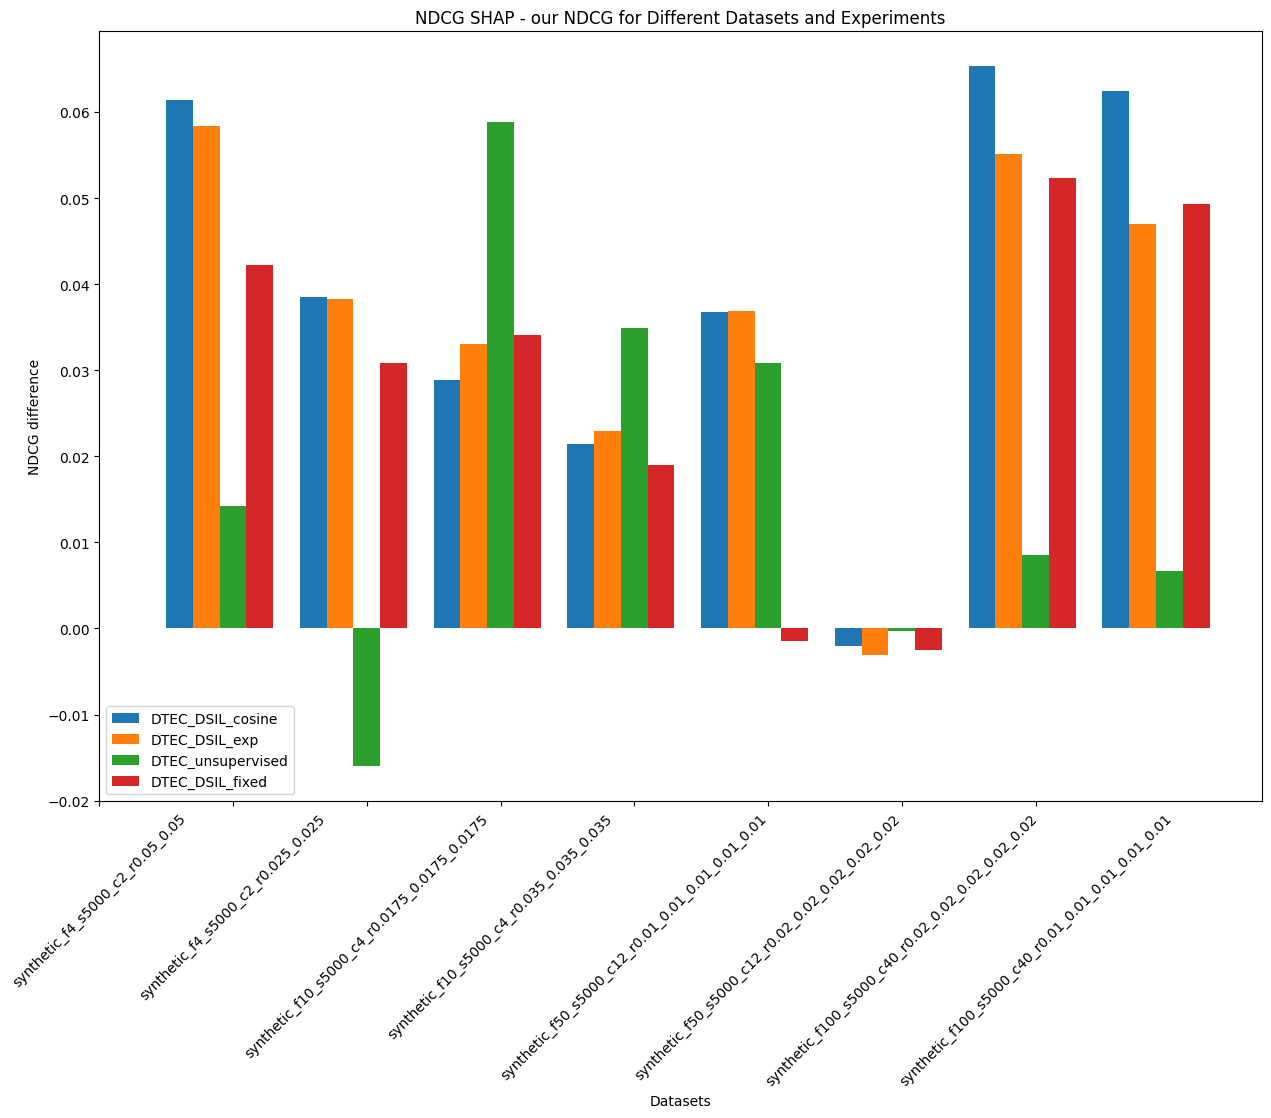

In [25]:
datasets = mean_df["dataset_name"].unique()
experiments = mean_df["experiment"].unique()
num_datasets = len(datasets)
num_experiments = len(experiments)

r = np.arange(num_datasets)
bar_width = 0.2
# Create the plot
fig, ax = plt.subplots(figsize=(15, 10))

# Plot each experiment's accuracy as a bar
for i, experiment in enumerate(experiments):
    experiment_mean = mean_df[mean_df["experiment"] == experiment]
    experiment_std = std_df[std_df["experiment"] == experiment]
    shap_ndcg = experiment_mean.sort_values(by="dataset_name")["shap_feature_importance_ndcg"].values
    shap_ndcg_std = experiment_std.sort_values(by="dataset_name")["shap_feature_importance_ndcg"].values
    feat_imp_ndcg = experiment_mean.sort_values(by="dataset_name")["feature_importance_ndcg"].values
    feat_imp_ndcg_std = experiment_std.sort_values(by="dataset_name")["feature_importance_ndcg"].values
    ax.bar(r + i * bar_width, shap_ndcg - feat_imp_ndcg, width=bar_width,  label=experiment)
    # ax.bar(r + i * bar_width, feat_imp_ndcg, width=bar_width, yerr=feat_imp_ndcg_std, label=experiment)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Datasets')
ax.set_ylabel('NDCG difference')
ax.set_title('NDCG SHAP - our NDCG for Different Datasets and Experiments')
ax.set_xticks(r - 1 + bar_width * (num_experiments) / 2)
ax.set_xticklabels(datasets)
ax.legend()

# Show the plot
plt.xticks(rotation=45)
plt.show()

([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, 'synthetic_f4_s5000_c2_r0.05_0.05'),
  Text(1, 0, 'synthetic_f4_s5000_c2_r0.025_0.025'),
  Text(2, 0, 'synthetic_f10_s5000_c4_r0.0175_0.0175_0.0175'),
  Text(3, 0, 'synthetic_f10_s5000_c4_r0.035_0.035_0.035'),
  Text(4, 0, 'synthetic_f50_s5000_c12_r0.01_0.01_0.01_0.01_0.01'),
  Text(5, 0, 'synthetic_f50_s5000_c12_r0.02_0.02_0.02_0.02_0.02'),
  Text(6, 0, 'synthetic_f100_s5000_c40_r0.02_0.02_0.02_0.02_0.02'),
  Text(7, 0, 'synthetic_f100_s5000_c40_r0.01_0.01_0.01_0.01_0.01')])

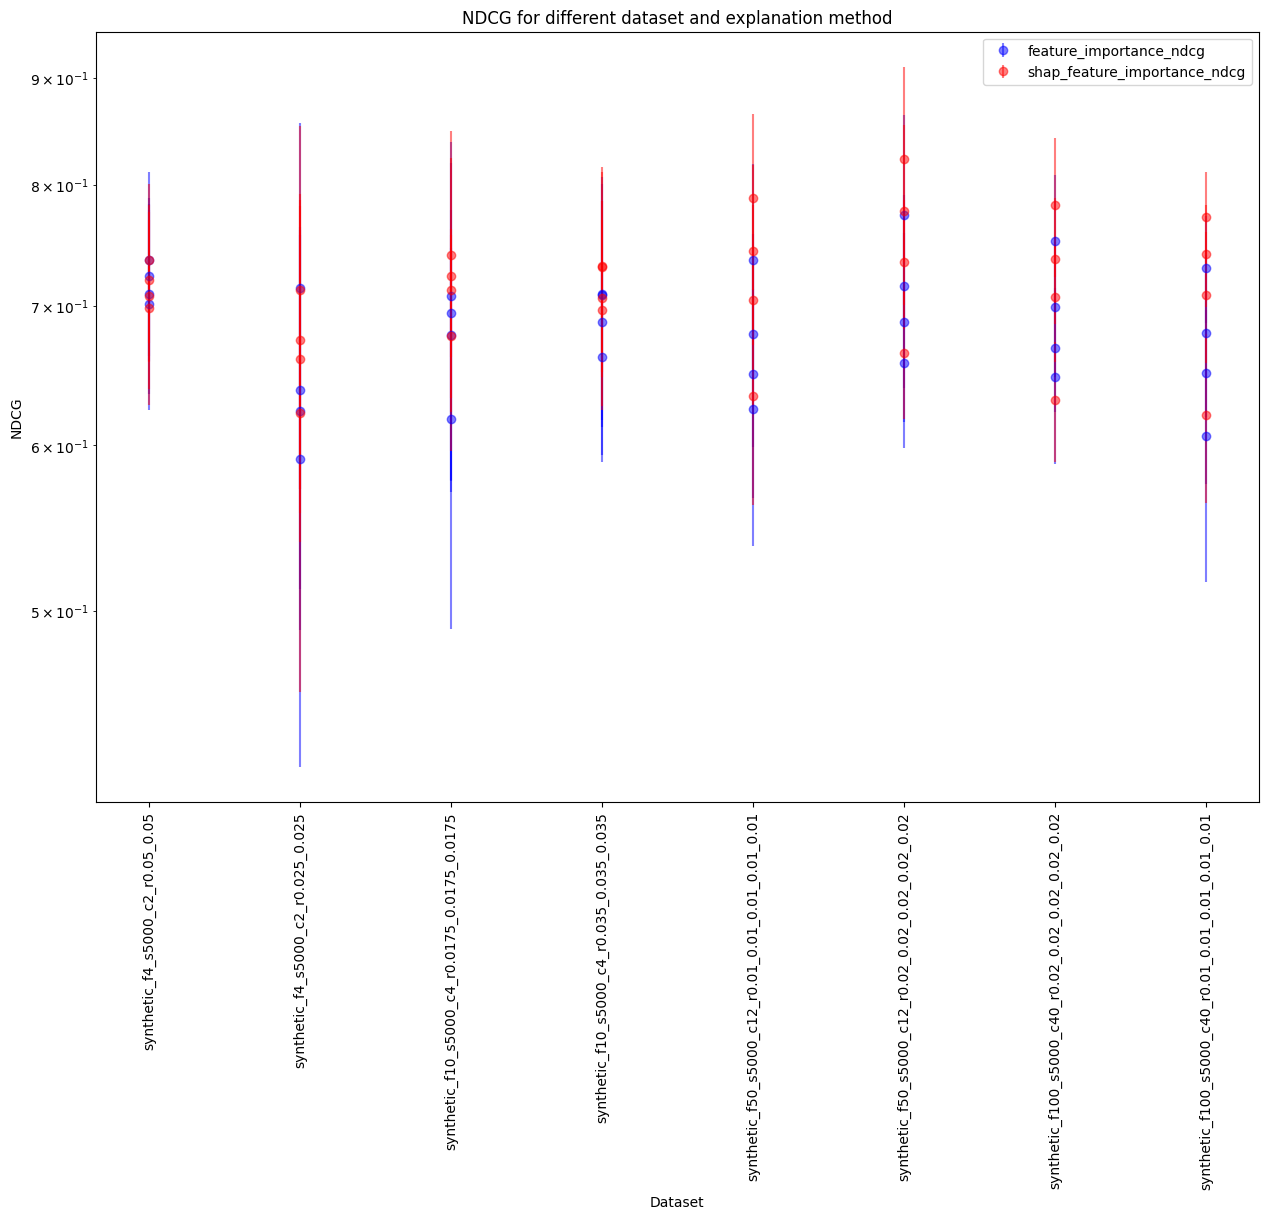

In [15]:
# Same but to compare explanation methods local or shap for different dataset
plt.figure(figsize=(15, 10))
colors= {"feature_importance_ndcg": "blue", "shap_feature_importance_ndcg": "red"}
for i, dataset_name in enumerate(mean_df["dataset_name"].unique()):
    dataset_mean = mean_df[mean_df["dataset_name"] == dataset_name]
    dataset_std = std_df[std_df["dataset_name"] == dataset_name]
    for j, explanation_method in enumerate(["feature_importance_ndcg", "shap_feature_importance_ndcg"]):
        experiment_mean = dataset_mean[explanation_method]
        experiment_std = dataset_std[explanation_method]
        label = explanation_method if i == 0 else None
        # One line for each explanation method, one color for each dataset
        plt.errorbar(dataset_mean["dataset_name"], experiment_mean, yerr=experiment_std, label=label, fmt='o', alpha=0.5, color=colors[explanation_method])
plt.legend()
plt.title("NDCG for different dataset and explanation method")
plt.xlabel("Dataset")
plt.ylabel("NDCG")
plt.yscale("log")
plt.xticks(rotation=90)

([0, 1, 2, 3],
 [Text(0, 0, 'DTEC_DSIL_cosine'),
  Text(1, 0, 'DTEC_DSIL_exp'),
  Text(2, 0, 'DTEC_unsupervised'),
  Text(3, 0, 'DTEC_DSIL_fixed')])

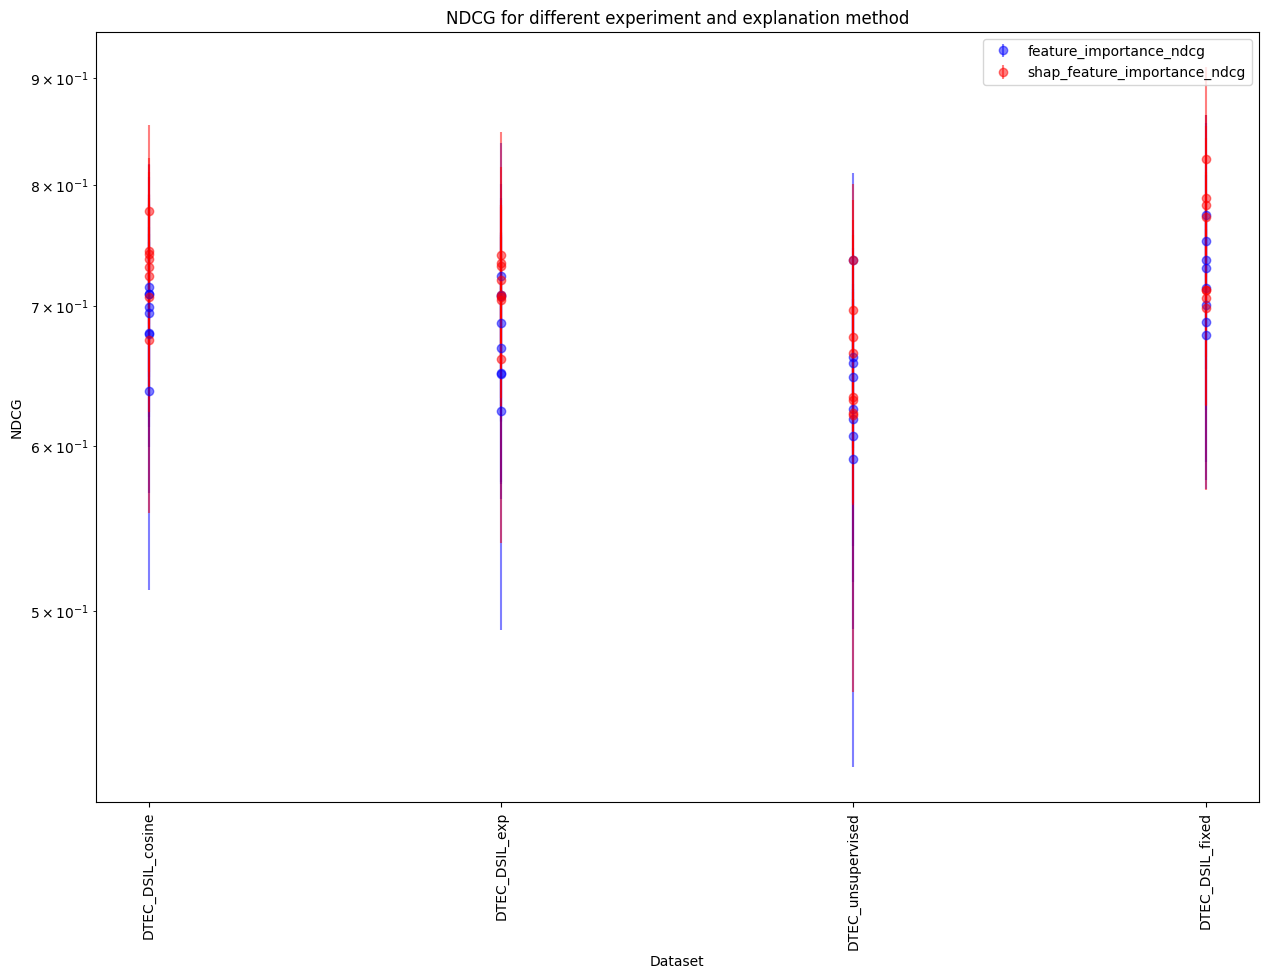

In [16]:
# Same but to compare explanation methods local or shap for different dataset
plt.figure(figsize=(15, 10))
colors= {"feature_importance_ndcg": "blue", "shap_feature_importance_ndcg": "red"}
for i, experiment in enumerate(mean_df["experiment"].unique()):
    dataset_mean = mean_df[mean_df["experiment"] == experiment]
    dataset_std = std_df[std_df["experiment"] == experiment]
    for j, explanation_method in enumerate(["feature_importance_ndcg", "shap_feature_importance_ndcg"]):
        experiment_mean = dataset_mean[explanation_method]
        experiment_std = dataset_std[explanation_method]
        label = explanation_method if i == 0 else None
        # One line for each explanation method, one color for each dataset
        plt.errorbar(dataset_mean["experiment"], experiment_mean, yerr=experiment_std, label=label, fmt='o', alpha=0.5, color=colors[explanation_method])
plt.legend()
plt.title("NDCG for different experiment and explanation method")
plt.xlabel("Dataset")
plt.ylabel("NDCG")
plt.yscale("log")
plt.xticks(rotation=90)


In [17]:
baseline_comp_dataset = pd.DataFrame()
temp_df = full_results_df
temp_df['dataset_name'] = temp_df['dataset_name'] + "_" + temp_df['dataset_version']
for dataset_name in full_results_df["dataset_name"].unique():
    dataset_results = full_results_df[full_results_df["dataset_name"] == dataset_name]
    baseline_results = dataset_results[dataset_results["training_method"] == "unsupervised"]
    dataset_results['f1_score_diff'] = dataset_results['f1_score'] - baseline_results['f1_score'].values[0]
    dataset_results['aucroc_diff'] = dataset_results['aucroc'] - baseline_results['aucroc'].values[0]
    dataset_results['aucroc_ratio'] = dataset_results['aucroc'] / baseline_results['aucroc'].values[0]
    dataset_results['f1_score_ratio'] = dataset_results['f1_score'] / baseline_results['f1_score'].values[0]
    dataset_results['feature_importance_ndcg_diff'] = dataset_results['feature_importance_ndcg'] - baseline_results['feature_importance_ndcg'].values[0]
    dataset_results['shap_feature_importance_ndcg_diff'] = dataset_results['shap_feature_importance_ndcg'] - baseline_results['shap_feature_importance_ndcg'].values[0]
    baseline_comp_dataset = pd.concat([baseline_comp_dataset, dataset_results]) 

/tmp/ipykernel_2917414/842341016.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_results['f1_score_diff'] = dataset_results['f1_score'] - baseline_results['f1_score'].values[0]
/tmp/ipykernel_2917414/842341016.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_results['aucroc_diff'] = dataset_results['aucroc'] - baseline_results['aucroc'].values[0]
/tmp/ipykernel_2917414/842341016.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

In [18]:
baseline_comp_dataset

,training_time,inference_time,f1_score,dataset_name,training_method,random_seed,aucroc,feature_importance_ndcg,shap_feature_importance_ndcg,global_explanation_time,local_explanation_time,shap_explanation_time,experiment,dataset_version,f1_score_diff,aucroc_diff,aucroc_ratio,f1_score_ratio,feature_importance_ndcg_diff,shap_feature_importance_ndcg_diff
0,152.779132,0.055405,0.776000,synthetic_f100_s5000_c40_r0.02_0.02_0.02_0.02_...,unsupervised,0,0.901602,0.633476,0.623885,128.561823,684.078592,2369.153448,DTEC_unsupervised,v3,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
0,595.397878,0.026412,0.810286,synthetic_f100_s5000_c40_r0.02_0.02_0.02_0.02_...,dataset_sampling,0,0.921986,0.660240,0.709747,127.596359,675.550599,2346.288306,DTEC_DSIL_cosine,v3,0.034286,0.020383,1.022608,1.044183,0.026763,0.085862
0,461.652462,0.025944,0.829143,synthetic_f100_s5000_c40_r0.02_0.02_0.02_0.02_...,dataset_sampling,0,0.929714,0.703243,0.739218,127.130440,682.233099,2344.191174,DTEC_DSIL_fixed,v3,0.053143,0.028112,1.031180,1.068483,0.069766,0.115333
0,594.556682,0.026680,0.804000,synthetic_f100_s5000_c40_r0.02_0.02_0.02_0.02_...,dataset_sampling,0,0.918063,0.655239,0.703555,125.741148,677.175344,2339.961859,DTEC_DSIL_exp,v3,0.028000,0.016460,1.018257,1.036082,0.021763,0.079670
0,149.941046,0.053073,0.884571,synthetic_f100_s5000_c40_r0.02_0.02_0.02_0.02_...,unsupervised,0,0.972246,0.744063,0.696045,126.614622,680.733151,2369.362068,DTEC_unsupervised,v2,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,626.512878,0.028064,0.858857,synthetic_f100_s5000_c40_r0.01_0.01_0.01_0.01_...,dataset_sampling,0,0.965427,0.661026,0.728862,126.060954,676.313939,2338.786874,DTEC_DSIL_exp,v2,0.038286,0.026173,1.027866,1.046657,0.038817,0.065318
0,146.671325,0.046738,0.634286,synthetic_f4_s5000_c2_r0.025_0.025_v1,unsupervised,0,0.857663,0.557834,0.630595,8.226875,127.743915,157.186176,DTEC_unsupervised,v1,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
0,472.114197,0.049675,0.720000,synthetic_f4_s5000_c2_r0.025_0.025_v1,dataset_sampling,0,0.891020,0.661292,0.719473,5.582620,132.456953,155.560820,DTEC_DSIL_cosine,v1,0.085714,0.033357,1.038893,1.135135,0.103459,0.088878
0,363.911325,0.041127,0.615714,synthetic_f4_s5000_c2_r0.025_0.025_v1,dataset_sampling,0,0.867413,0.603802,0.604526,5.373602,134.589061,160.233561,DTEC_DSIL_fixed,v1,-0.018571,0.009749,1.011367,0.970721,0.045969,-0.026069


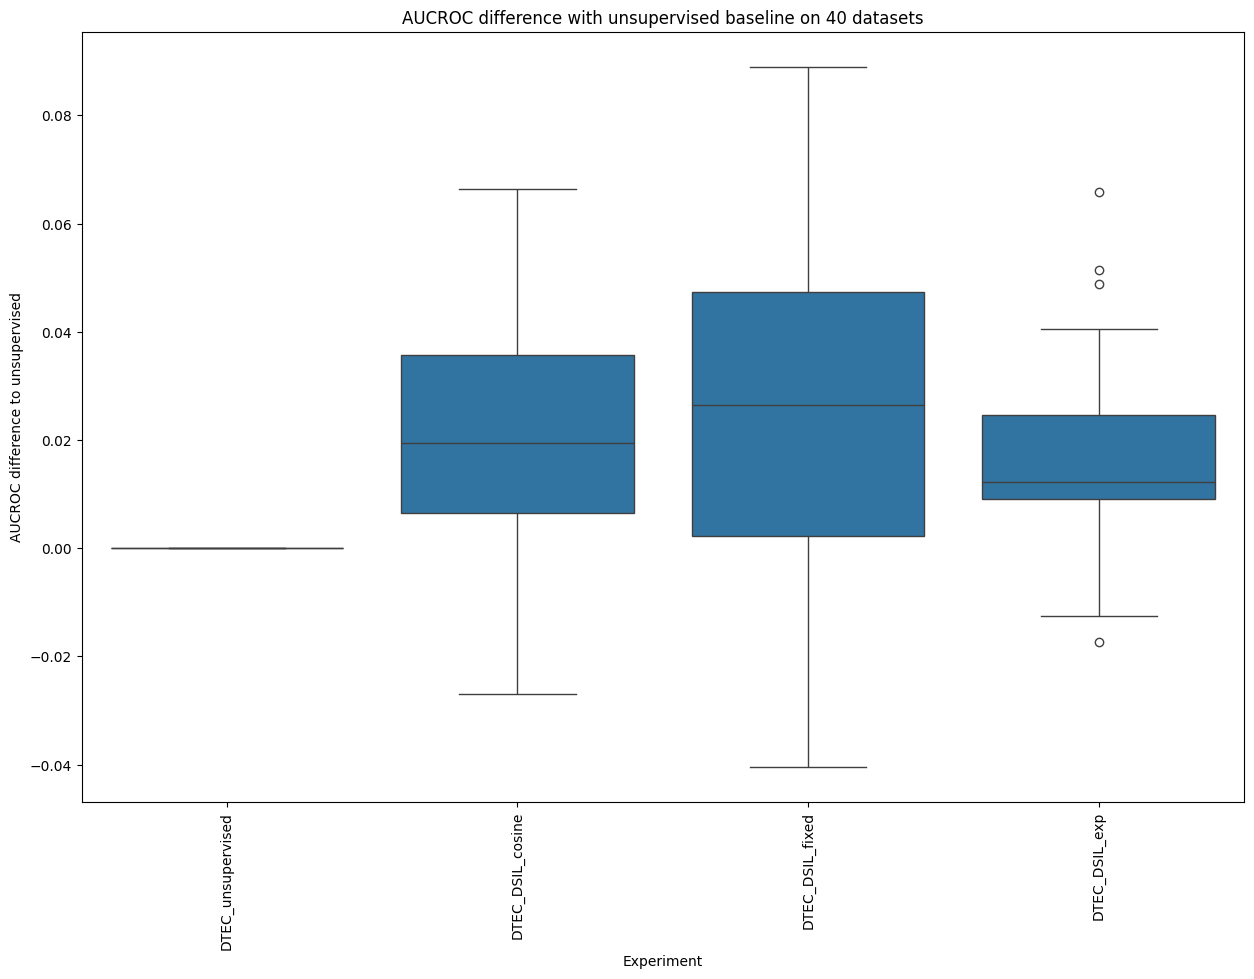

In [19]:
plt.figure(figsize=(15, 10))
sns.boxplot(data=baseline_comp_dataset, x="experiment", y="aucroc_diff")
plt.title(f"AUCROC difference with unsupervised baseline on {len(baseline_comp_dataset['dataset_name'].unique())} datasets")
plt.xticks(rotation=90)
plt.ylabel("AUCROC difference to unsupervised")
plt.xlabel('Experiment')
plt.show()

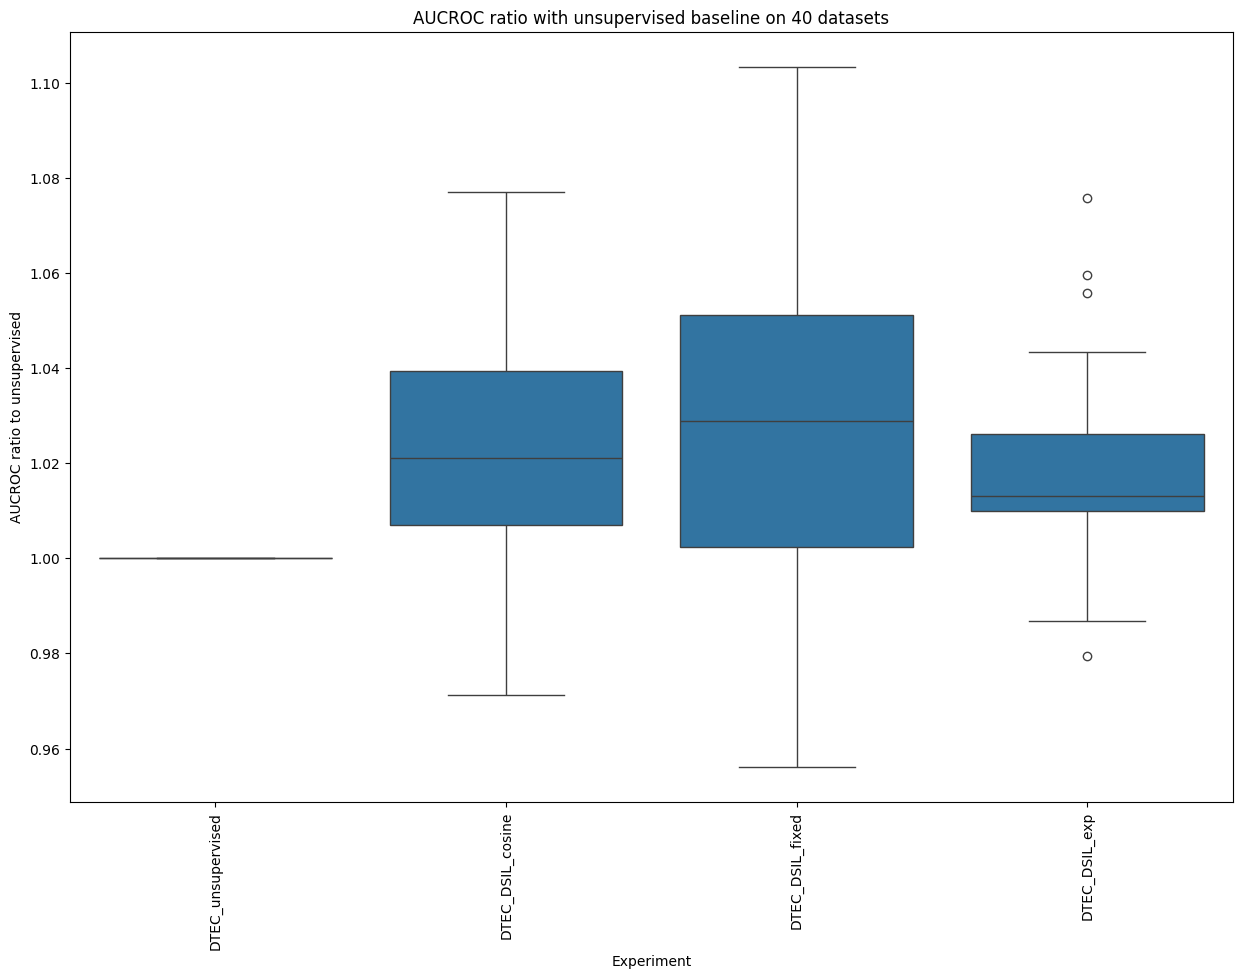

In [20]:
plt.figure(figsize=(15, 10))
sns.boxplot(data=baseline_comp_dataset, x="experiment", y="aucroc_ratio")
plt.title(f"AUCROC ratio with unsupervised baseline on {len(baseline_comp_dataset['dataset_name'].unique())} datasets")
plt.xticks(rotation=90)
plt.ylabel("AUCROC ratio to unsupervised")
plt.xlabel('Experiment')
plt.show()

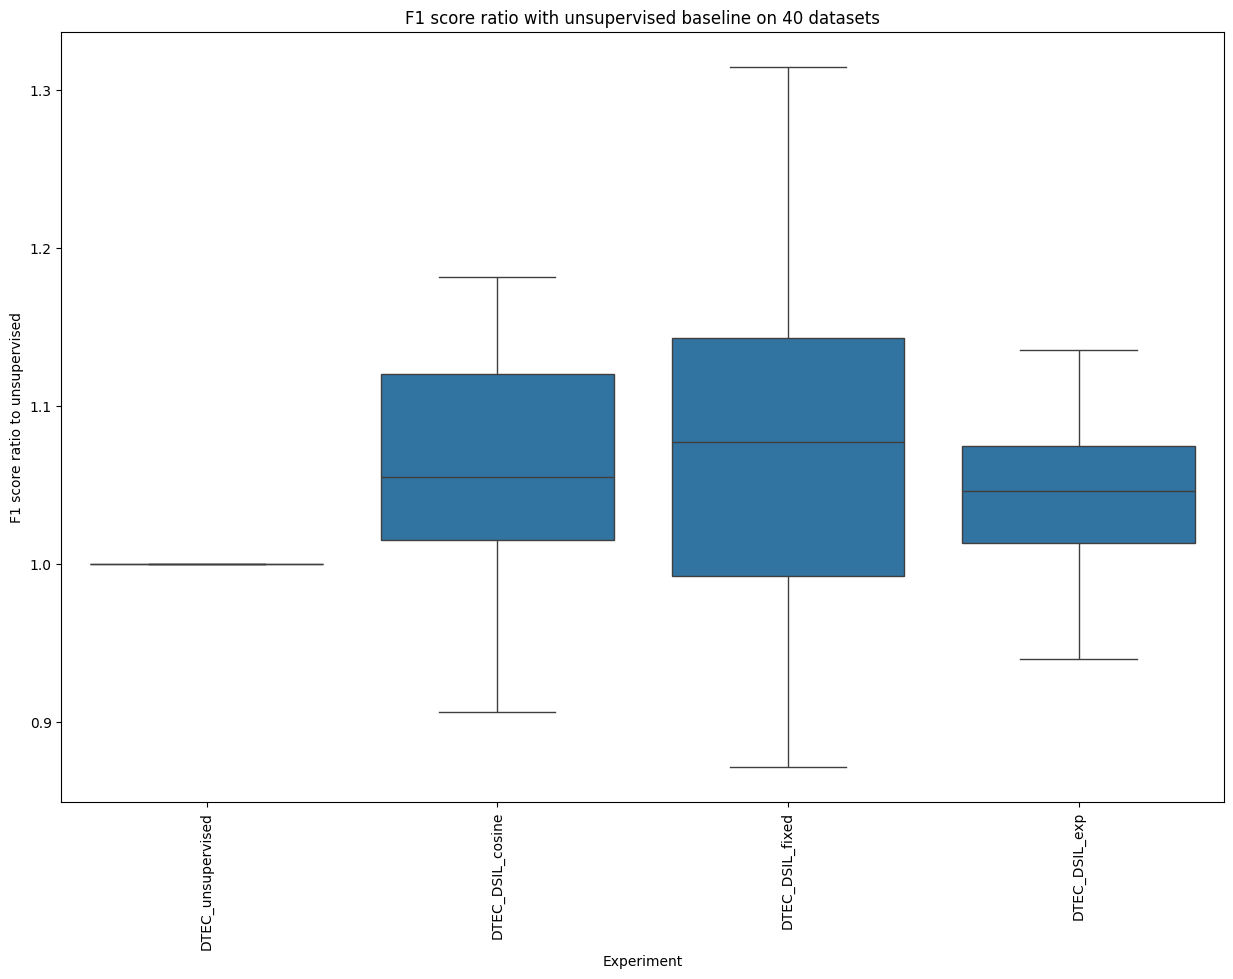

In [21]:
plt.figure(figsize=(15, 10))
sns.boxplot(data=baseline_comp_dataset, x="experiment", y="f1_score_ratio", showfliers=False)
plt.title(f"F1 score ratio with unsupervised baseline on {len(baseline_comp_dataset['dataset_name'].unique())} datasets")
plt.xticks(rotation=90)
plt.ylabel("F1 score ratio to unsupervised")
plt.xlabel('Experiment')
plt.show()

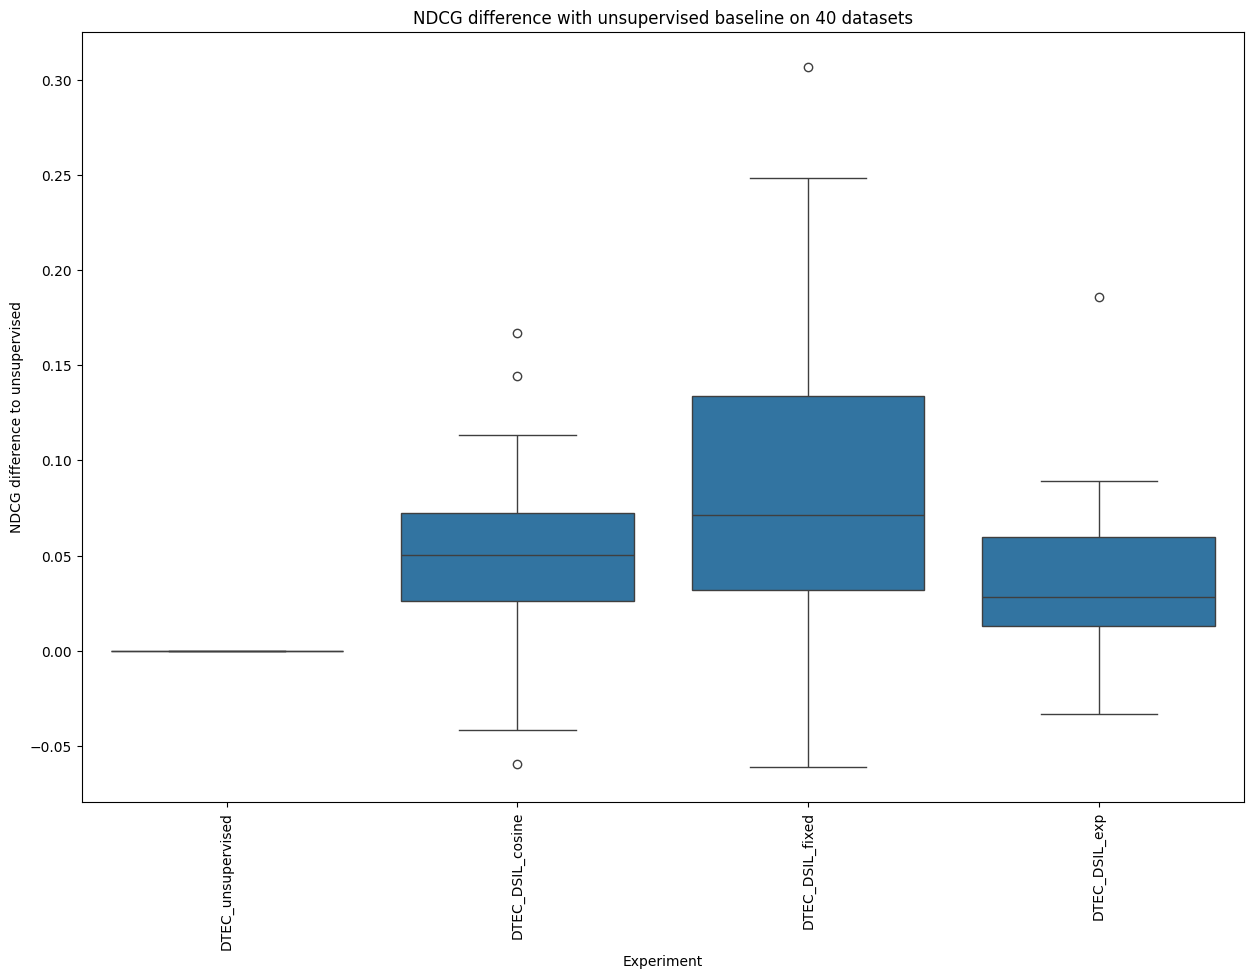

In [22]:
plt.figure(figsize=(15, 10))
sns.boxplot(data=baseline_comp_dataset, x="experiment", y="feature_importance_ndcg_diff")
plt.title(f"NDCG difference with unsupervised baseline on {len(baseline_comp_dataset['dataset_name'].unique())} datasets")
plt.xticks(rotation=90)
plt.ylabel("NDCG difference to unsupervised")
plt.xlabel('Experiment')
plt.show()


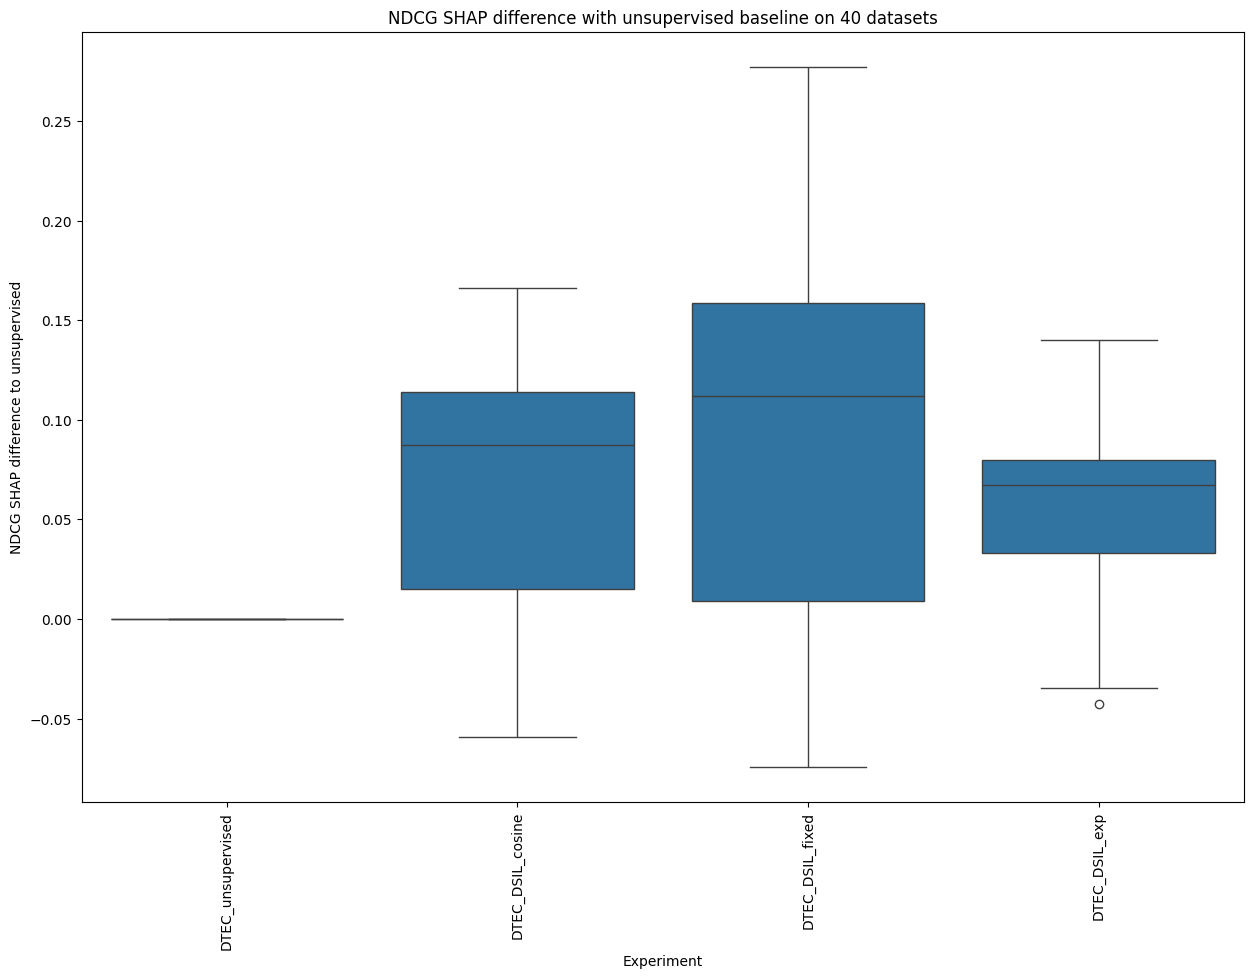

In [23]:
plt.figure(figsize=(15, 10))
sns.boxplot(data=baseline_comp_dataset, x="experiment", y="shap_feature_importance_ndcg_diff")
plt.title(f"NDCG SHAP difference with unsupervised baseline on {len(baseline_comp_dataset['dataset_name'].unique())} datasets")
plt.xticks(rotation=90)
plt.ylabel("NDCG SHAP difference to unsupervised")
plt.xlabel('Experiment')
plt.show()
